In "[Literary Pattern Recognition](https://www.journals.uchicago.edu/doi/full/10.1086/684353)", Long and So train a classifier to differentiate haiku poems from non-haiku poems, and find that many features help do so.  In class, we've discussed the importance of representation--how you *describe* a text computationally influences the kinds of things you are able to do with it.  While Long and So explore description in the context of classification, in this homework, you'll see how well you can design features that can differentiate these two classes *without* any supervision. Are you able to featurize a collection of poems such that two clusters (haiku/non-haiku) emerge when using KMeans clustering, with the text representation as your only degree of freedom?

In [1]:
import csv, os, re
import nltk
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from collections import Counter
import random

In [2]:
def read_texts(path, metadata, filepath_col):
    data=[]
    with open(metadata, encoding="utf-8") as file:
        csv_reader = csv.reader(file)
        next(csv_reader)
        for cols in csv_reader:
            poem_path=os.path.join(path, cols[filepath_col])
            if os.path.exists(poem_path):
                with open(poem_path, encoding="utf-8") as poem_file:
                    poem=poem_file.read()
                    data.append(poem)
    return data

Here we'll use data originally released on Github to support "Literary Pattern Recognition": [https://github.com/hoytlong/PatternRecognition](https://github.com/hoytlong/PatternRecognition)

In [3]:
haiku=read_texts("../data/haiku/long_so_haiku", "../data/haiku/Haikus.csv", 4)

In [4]:
others=read_texts("../data/haiku/long_so_others", "../data/haiku/OthersData.csv", 5)

In [5]:
# don't change anything within this code block

def run_all(haiku, others, feature_function):
    
    X, Y, featurize_vocab=feature_function(haiku, others)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    nmi=metrics.normalized_mutual_info_score(Y, kmeans.labels_)
    print("%.3f NMI" % nmi)

As one example, let's take a simple featurization and represent each poem by a binary indicator of the dictionary word types it contains.  "To be or not to be", for example, would be represented as {"to": 1, "be": 1, "or": 1, "not": 1}

In [6]:
# This function takes in a list of haiku poems and non-haiku poems, and returns:

# X (sparse matrix, with poems as rows and features as columns)
# Y (list of poem labels, with 1=haiku and 0=non-haiku)
# feature_vocab (dict mapping feature name to feature ID)

def unigram_featurize_all(haiku, others):

    def unigram_featurize(poem, feature_vocab):
        
        # featurize text by just noting the binary presence of words within it
        
        feats={}

        tokens=nltk.word_tokenize(poem.lower())
        for token in tokens:
            if token not in feature_vocab:
                feature_vocab[token]=len(feature_vocab)
            feats[feature_vocab[token]]=1
        return feats

    feature_vocab={}
    data=[]
    Y=[]

    for poem in haiku:
        feats=unigram_featurize(poem, feature_vocab)
        data.append(feats)
        Y.append(1)
    for poem in others:
        feats=unigram_featurize(poem, feature_vocab)
        data.append(feats)
        Y.append(0)
    
    # since the data above has all haiku ordered before non-haiku, let's shuffle them
    temp = list(zip(data, Y))
    random.shuffle(temp)
    data, Y = zip(*temp)

    # we'll use a sparse representation since our features are sparse
    X=sparse.lil_matrix((len(data), len(feature_vocab)))

    for idx,feats in enumerate(data):
        for f in feats:
            X[idx,f]=feats[f]
    
    return X, Y, feature_vocab

This method yields an NMI of ~0.07 (with some variability due to the randomness of KMeans)

In [7]:
run_all(haiku, others, unigram_featurize_all)

0.057 NMI


**Q1**: Copy the `unigram_featurize_all` code above and adapt it to create your own featurization method named `fancy_featurize_all`.  You may use whatever information you like to represent these poems for the purposes of clustering them into two categories, but you must use the KMeans clustering (with 2 clusters) as defined in `run_all`.  Use your own understanding of haiku, or read the Long and So article above for other ideas.  Are you able to improve over an NMI of 0.07?

In [8]:
!pip install pyphen


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import string
import numpy as np
import pyphen
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# initialize the syllabifier for English
dic = pyphen.Pyphen(lang='en')

In [11]:
# line tokenizer: read peoms in line by line
def store_lines(text):
    lines = [line.replace('\t', ' ').strip() for line in text.split('\n') if line and line.strip()]
    return lines

In [12]:
def get_syllables(poem):
    
    lines = store_lines(poem)
    tokenized_lines = [nltk.word_tokenize(line.lower()) for line in lines]
    SYL = []
    roman = 0
    RI = {}
    
    for line in tokenized_lines:
        syllables = []
        for word in line:
            # syllabify each line into individual syllables
            syllables.extend(dic.inserted(word).split('-'))
            # check if the poem has verse indicator - Roman numerals
            if word in ["ii", "iii", "iv", "v", "vi"]:
                roman += 1
        SYL.append((syllables, len(syllables)))
    
    i = 0
    feat = {}
    for line, count in SYL:
    # each feature would be each line, the corresponding value is the number of syllable for that line
        feat[i+1] = count
        i += 1
    
    # adding another feature at the beginning to indicate whether the poem has multiple verses
    if roman > 0:
        RI[0] = 1
    else:
        RI[0] = 0
    
    RI.update(feat)
    
    return RI

In [13]:
def dicts_to_arrays(dict_list):
    
    # since poems have different lengths, creating a matrix with empty lines padded with 0
    max_key = max(max(d.keys(), default=-1) for d in dict_list) + 1
    arrays = []
    for d in dict_list:
        array = [d.get(i, 0) for i in range(max_key)]
        arrays.append(array)
    
    return arrays

In [14]:
def fancy_featurize_all(haiku, others):
    feature_vocab = {}
    data = []
    Y = []
    
    for idx, h in enumerate(haiku):
        #print("haiku", idx, get_syllables_2(h))
        data.append(get_syllables(h))
        Y.append(1)
    
    for idx, p in enumerate(others):
        #print("other", idx, get_syllables_2(p))
        data.append(get_syllables(p))
        Y.append(0)
    
    X = np.array(dicts_to_arrays(data))
    temp = list(zip(X, Y))
    random.shuffle(temp)
    X, Y = zip(*temp)
    
    return X, Y, feature_vocab

In [15]:
run_all(haiku, others, fancy_featurize_all)

0.079 NMI


**Q2**: Describe your method for featurization in 100 words and why you expect it to be able to separate haiku poems from non-haiku poems in this data.

For this task, I did not go for any methods involving pre-trained or fine-tuned embeddings, but I tried to solve it by referring to the analytical features found in haiku.

What I did first was to keep track of the syllable count for each line to capture the difference between haiku and other poems. Although it is not always the case that English haikus follow the syllable pattern observed in Japanese haikus, they are still short in terms of syllable count for each line. The first histogram, showing the distribution of syllable counts for each line, illustrates this point.

Another analytical feature is that English haikus tend to be shorter compared to non-haikus. Again, this is not always the case but it's worth a try. This feature is implicitly encoded, with each feature representing a line. There are definitely short poems, and in this case, features for empty lines are padded with 0. The second histogram below shows the distribution of the total length of a haiku/non-haiku.

The final analytical feature is to encode whether the poem has multiple verses or stanzas, which are ordered by Roman numerals (I, II, III, etc.). This is binary coding, either 0 or 1.

Although these features make sense to me, the results are not as ideal as I hoped. I find this experiment interesting because all of the features are not relevant to the content or semantics of the poem but are more pertinent to the style. I'm sure that features encoding the semantics of the poem might help, but it's worth a try to see how much the style matters in terms of clustering these two categories.

In [16]:
SYL_AVG_others = []
LEN_MAX_others = []
for poem in others:
    SYL_AVG_others.append(np.mean([count for line, count in get_syllables(poem).items()]))
    LEN_MAX_others.append(np.max([line for line, count in get_syllables(poem).items()]))

In [17]:
SYL_AVG_haiku = []
LEN_MAX_haiku = []
for poem in haiku:
    SYL_AVG_haiku.append(np.mean([count for line, count in get_syllables(poem).items()]))
    LEN_MAX_haiku.append(np.max([line for line, count in get_syllables(poem).items()]))

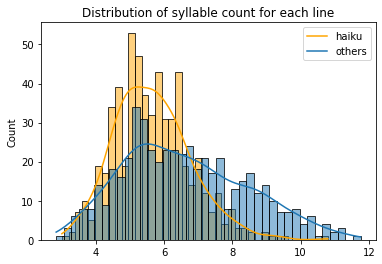

In [18]:
sns.histplot(SYL_AVG_haiku, bins=40, color='orange', kde=True)
sns.histplot(SYL_AVG_others, bins=40, kde=True)
plt.legend(labels=['haiku', 'others'])
plt.title('Distribution of syllable count for each line');

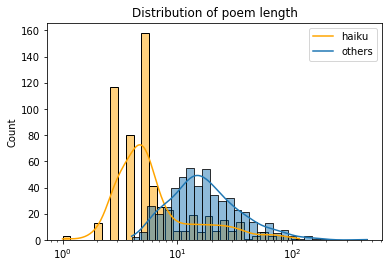

In [19]:
sns.histplot(LEN_MAX_haiku, bins=30, color='orange', kde=True, log_scale=True)
sns.histplot(LEN_MAX_others, bins=30, kde=True, log_scale=True)
plt.legend(labels=['haiku', 'others'])
plt.title('Distribution of poem length');